# Отбор дескрипторов

## Необходимые для выполнения тюториала

* scikit-learn 
* sklearn-genetic
* pandas
* matplotlib

## Теоретические основы

### Проблемы, связанные с отбором дескрипторов
  
1. Интенсивный отбор дескрипторов без должной валидации является основным фактором, приводящим к переобучению при построении моделей "структура-свойство". Этот эффект получил название ***смещенность отбора дескрипторов*** (англ. *selection bias, descriptor selection bias, variable selection bias, feature selection bias, competition bias*) и является частью общей проблемы, известной как *смещенность отбора модели* (англ. *model selection bias*). 
2. При отборе дескрипторов может быть потеряна ценная информация, заключенная в неотобранных дескрипторах.

## Внутренний и внешний перекрестный контроль

![InternalCV1](img/InternalCV1.png)

Рис. 1. Использование внутреннего перекрестного контроля при отборе дексрипторов: отбор дескрипторов осуществляется до обучения модели.  

![InternalCV2](img/InternalCV2.png)

Рис. 2. Использование внутреннего перекрестного контроля при отборе дексрипторов: отбор дескрипторов используется для оптимизации модели.  

![ExternalCV](img/ExternalCV.png)

Рис. 3. Использование внешнего перекрестного контроля при отборе дескрипторов: дескрипторы отбираются независимо на каждом этапе кросс-валидации.

----

Наиболее правильный алгоритм представлен на 
**рисунке 1**, так как отбор дескрипторов проводится на начальном этапе, что важно для корректности построения модели.

Алгоритм на **рис. 2**: Более сложная структура, включающая дополнительные этапы. Это может быть полезно для глубокого анализа, но на практике может быть избыточным.

Недочёты алгоритма на **рис. 3**: Отбор дескрипторов выполнен после формирования обучающей выборки, что может привести к утечке данных.

---

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from pandas import read_csv
from math import sqrt, inf
from operator import itemgetter
%matplotlib inline
import matplotlib.pyplot as plt
from genetic_selection import GeneticSelectionCV

Загрузим набор данных, состоящий из 100 дескрипторов - случайных чисел.

In [2]:
X = read_csv('data/alkan-bp-louse100.csv')
Y = X.pop('class')

Разделим данные на 2 выборки: обучающую и контрольную.  Разделение производится случайным образом для предотвращения возникновения зависимостей из-за упорядоченности набора данных.

In [3]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.1, random_state=42)

Построим модель и оценим ее предсказательную способность с помощью внутреннего перекрестного контроля. 
В качестве метода машинного обучения используем линейную регрессию. 

In [4]:
Ypred = cross_val_predict(LinearRegression(), Xtrain, Ytrain, cv=5)
sqrt(mean_squared_error(Ytrain, Ypred)), r2_score(Ytrain, Ypred)

(69.2000468577244, -1.9646441093254872)

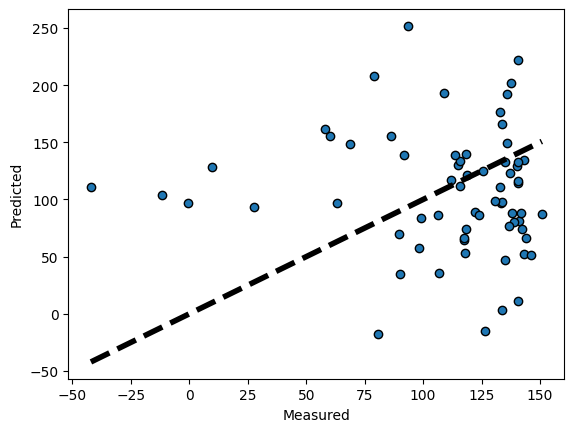

In [5]:
fig, ax = plt.subplots()
ax.scatter(Ytrain, Ypred, edgecolors=(0, 0, 0))
ax.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Видно, что получить модель не удается, что вполне очевидно, т.к. набор данных представляет собой просто шум.

Попробуем предсказать контрольную выборку на модели, обученной на всем обучающем наборе данных

In [6]:
Ypred = LinearRegression().fit(Xtrain, Ytrain).predict(Xtest)
sqrt(mean_squared_error(Ytest, Ypred)), r2_score(Ytest, Ypred)

(87.66231444321929, -0.5825492198570001)

Ниже представлена реализация метода отбора дескрипторов `forward selection` (`метод включения`).

В данном методе к текущему набору отобранных дескрипторов добавляют по одному новые таким образом, чтобы на каждом этапе оказался включенным наиболее "ценный" дескриптор, приводящий к наилучшим статистическим характеристикам построенной модели.

In [7]:
def forward_selection(X, Y):
    lr = LinearRegression()
    ft = set(range(X.shape[1]))
    var = Y.var()
    bf = []

    rss = inf
    while ft:
        f_rss = {}
        for f in ft:
            s = X.iloc[:, bf + [f]]
            y = lr.fit(s, Y).predict(s)
            f_rss[f] = ((y - Y) ** 2).sum()

        f, rss_next = min(f_rss.items(), key=itemgetter(1))

        if (rss - rss_next) / var > 1:
            rss = rss_next
            bf.append(f)
            ft.discard(f)
        else:
            break

        bf.sort()
    return bf

Выполним отбор дескрипторов на внутренней кореляции.

In [8]:
bf = forward_selection(Xtrain, Ytrain)
Xfs = Xtrain.iloc[:, bf]  # отобранные дескрипторы обучающей выборки

Выполним оценку предсказательной способности полученной модели с помощью внутренней кросс-валидации.  
Ниже показано, что модель имеет положительное значение R2. Однако, как уже было сказано, набор данных был просто шумом. Это означает, что отбор дескрипторов может легко привести к ложному результату.

In [9]:
Ypred = cross_val_predict(LinearRegression(), Xfs, Ytrain, cv=5)
sqrt(mean_squared_error(Ytrain, Ypred)), r2_score(Ytrain, Ypred)

(32.730412854258645, 0.33677214829417557)

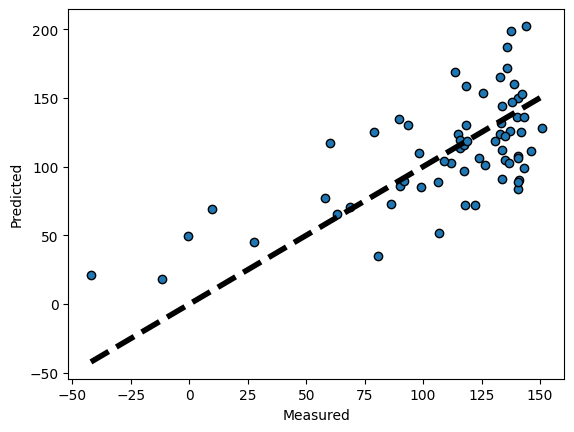

In [10]:
fig, ax = plt.subplots()
ax.scatter(Ytrain, Ypred, edgecolors=(0, 0, 0))
ax.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Чтобы избежать этого, необходимо делать валидацию на наборе данных, не участвовавших в отборе дескрипторов.  

In [11]:
Ypred = LinearRegression().fit(Xfs, Ytrain).predict(Xtest.iloc[:, bf])
sqrt(mean_squared_error(Ytest, Ypred)), r2_score(Ytest, Ypred)

(106.68849347177947, -1.3440481371786932)

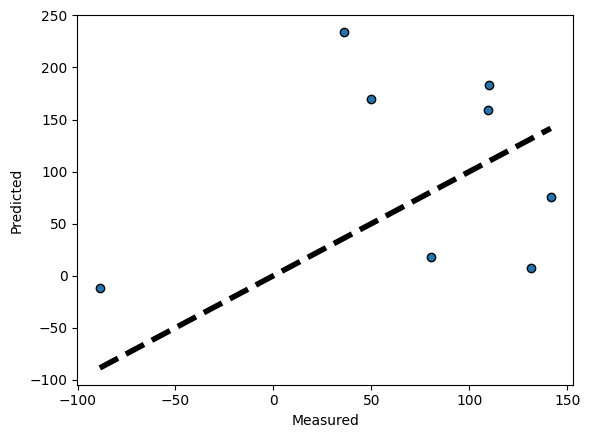

In [12]:
fig, ax = plt.subplots()
ax.scatter(Ytest, Ypred, edgecolors=(0, 0, 0))
ax.plot([Ytest.min(), Ytest.max()], [Ytest.min(), Ytest.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Видно, что модель не способна предсказать ничего.

Еще одним методом отбора дескрипторов является перебор комбинаций подмножества дескрипторов и проведение скользящего контроля для выбора оптимального набора.

In [13]:
# документация: https://sklearn-genetic.readthedocs.io/en/latest/examples.html
# pip install sklearn-genetic
# from genetic_selection import GeneticSelectionCV

gs = GeneticSelectionCV(LinearRegression(), cv=5, 
                        scoring='r2', n_population=100,
                        max_features=25, n_generations=100, n_jobs=1)

In [14]:
Xgs = gs.fit_transform(Xtrain, Ytrain)

e:\miniconda3\envs\ds\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  warnings.warn(


Видно, что в результате снова получилась модель с положительным R2

In [15]:
Ypred = cross_val_predict(LinearRegression(), Xgs, Ytrain, cv=5)
sqrt(mean_squared_error(Ytrain, Ypred)), r2_score(Ytrain, Ypred)

(39.7583345397864, 0.02137533756779264)

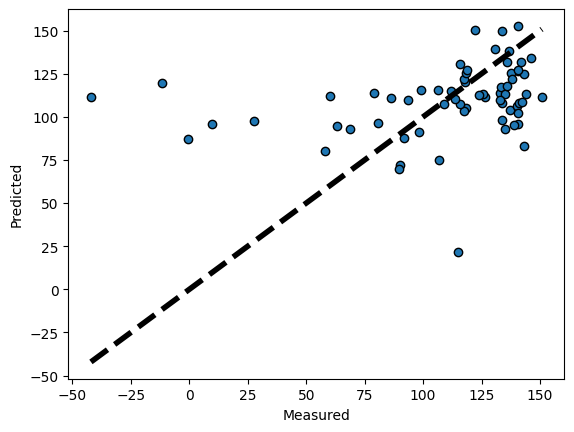

In [16]:
fig, ax = plt.subplots()
ax.scatter(Ytrain, Ypred, edgecolors=(0, 0, 0))
ax.plot([Ytrain.min(), Ytrain.max()], [Ytrain.min(), Ytrain.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

И ожидаемо неспособная предсказать тестовый набор.

In [17]:
Ypred = LinearRegression().fit(Xgs, Ytrain).predict(gs.transform(Xtest))
sqrt(mean_squared_error(Ytest, Ypred)), r2_score(Ytest, Ypred)

e:\miniconda3\envs\ds\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GeneticSelectionCV was fitted without feature names
  warnings.warn(


(72.61966180469366, -0.08602495568887703)

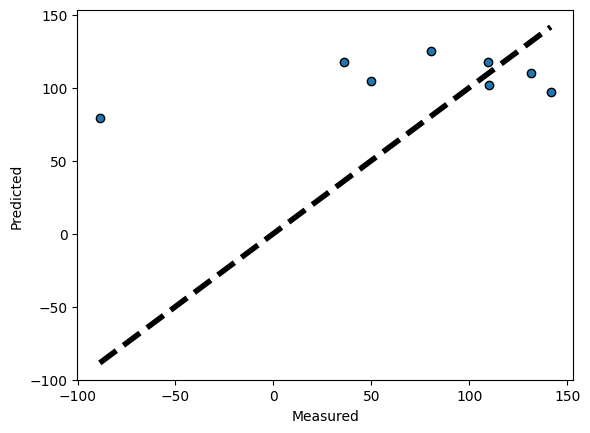

In [18]:
fig, ax = plt.subplots()
ax.scatter(Ytest, Ypred, edgecolors=(0, 0, 0))
ax.plot([Ytest.min(), Ytest.max()], [Ytest.min(), Ytest.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Таким образом, в случае необходимости оценки предсказательной способности моделей "структура-свойство" (QSAR-моделей), полученных с использованием автоматически отобранных дескрипторов, следует использовать внешний перекрестный контроль. В ином случае использование соединений из внешней контрольной выборки для отбора дескрипторов приводит к ошибочным или переобученным моделям. 
Выбор метода отбора дескрипторов зависит от пользователя, самое главное - необходимо корректно оценить, не было ли переобучения, для чего требуется иметь сбалансированную внешнюю контрольную выборку, которая НЕ ДОЛЖНА быть использована для отбора дескрипторов.